#Trabalho de Tópicos Especiais em Econometria 

##Aluno: Gustavo Alovisi



Este trabalho realiza a análise econométrica da estimação de um modelo de Regressão Linear Simples por Mínimos Quadrados Ordinários de duas séries temporais, Taxa Mensal de Juros de operações de crédito do SFN do Brasil e Taxa de Inadimplência mensal do SFN do Brasil. A variável independente é a Taxa de Juros e a variável dependente é a Taxa de Inadimplência. A análise busca seguir a metodologia de Box and Jenkings para modelagem de séries temporais e princípios da computação científica. 

####Importação das bibliotecas:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sqlite3
import statsmodels.tsa.stattools as smtsa
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.stats.diagnostic as smstats
import statsmodels.tsa.vector_ar as smcoint

### Carregamento de dados através da API do Banco Central do Brasil. 
Foi carregada a Taxa de Inadimplência mensal em % e a média da Taxa de Juros Mensal para operações de crédito no Brasil, através da API do Banco Central do Brasil, de 2011 a 2018, utilizando pandas. 

In [4]:
jurosmedmensal= pd.read_csv('http://api.bcb.gov.br/dados/serie/bcdata.sgs.25433/dados?formato=csv',
                  sep = ';', encoding = 'utf-8', decimal = ',')
txinadimplencia = pd.read_csv  ('http://api.bcb.gov.br/dados/serie/bcdata.sgs.21082/dados?formato=csv',
                                sep = ';', encoding = 'utf-8', decimal = ',')


#### Exploração inicial dos dados: 

In [6]:
jurosmedmensal.head()

,data,valor
0,01/03/2011,2.05
1,01/04/2011,2.09
2,01/05/2011,2.08
3,01/06/2011,2.07
4,01/07/2011,2.08


In [8]:
txinadimplencia.head()


,data,valor
0,01/03/2011,3.18
1,01/04/2011,3.25
2,01/05/2011,3.37
3,01/06/2011,3.33
4,01/07/2011,3.42


Um pouco de data wrangling para juntar nossos dados em um único dataframe.

In [9]:
txinadimplencia.columns = ['data1', 'txinadimp']
jurosmedmensal.columns = ['data2', 'juros']
dataframe = [txinadimplencia, jurosmedmensal]
dataframe = pd.concat(dataframe, 1)
dataframe = dataframe.drop('data2', 1)
dataframe.head()


,data1,txinadimp,juros
0,01/03/2011,3.18,2.05
1,01/04/2011,3.25,2.09
2,01/05/2011,3.37,2.08
3,01/06/2011,3.33,2.07
4,01/07/2011,3.42,2.08


### Criação de um banco de dados para nosso trabalho:

Com os dados carregados em um dataframe do pandas, iremos salvar nossos dados em um banco de dados para o uso posterior, através da integração pandas-sqlite3 (.to_sql)
Utiliza-se o comando SQL "CREATE TABLE IF NOT EXISTS" para criar a tabela se ela já não existe no banco de dados.  

In [10]:
database = sqlite3.connect('dados.db')
c = database.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS variaveis (data text, txjuros real, inadimplencia real)''')

#c.executemany('INSERT into variaveis VALUES (?,?,?)', dataframe)
dataframe.to_sql("variaveis", database, if_exists = 'replace') 


Carregando os dados do banco de dados local:

In [11]:
econvars = pd.read_sql_query("SELECT * FROM variaveis;", database)
econvars.head()

,index,data1,txinadimp,juros
0,0,01/03/2011,3.18,2.05
1,1,01/04/2011,3.25,2.09
2,2,01/05/2011,3.37,2.08
3,3,01/06/2011,3.33,2.07
4,4,01/07/2011,3.42,2.08


###  Análise Exploratória 

Vamos printar o gráfico da série da taxa de juros em relação ao tempo e da inadimplência em relação ao tempo: 

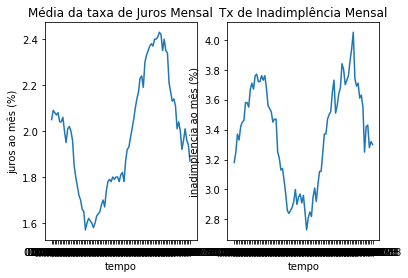

In [12]:
plt.subplot(121)
grafJuros = plt.plot(econvars.data1, econvars.juros)
plt.title('Média da taxa de Juros Mensal')
plt.xlabel("tempo")
plt.ylabel("juros ao mês (%)")

plt.subplot(122)
grafInadimplencia = plt.plot(econvars.data1, econvars.txinadimp)
plt.title("Tx de Inadimplência Mensal") 
plt.xlabel("tempo")
plt.ylabel("inadimplencia ao mês (%)")


plt.show()


Vamos agora printar um gráfico da correlação entre as séries e a matriz de correlação do coeficiente produto-momento de Pearson:

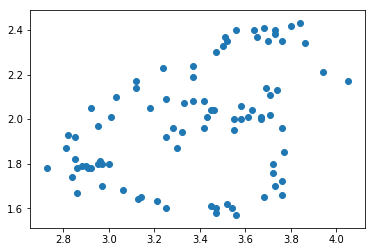

In [13]:
grafCorr = plt.scatter(econvars.txinadimp, econvars.juros)
plt.show() 

In [14]:
np.corrcoef(econvars.txinadimp, econvars.juros)

array([[ 1.        ,  0.41015367],
       [ 0.41015367,  1.        ]])

### Análise Econométrica: 

Para começar nossa modelagem de séries temporais seguindo a metodologia de Box and Jenkins, vamos testar a estacionariedade de nossas séries de dados. Para isso, iremos realizar um teste ADF para checar a presença de raiz unitária em nossas séries:

Para a taxa de inadimplência:

In [15]:
adf=smtsa.adfuller(econvars.txinadimp, regression=  'ctt')  # 'ctt' para checar a estacionariedade em tendência constante, linear e quadrática
adfoutput_inad = pd.Series(adf[0:4], index = ["Estatística do Teste:", "P-valor", "# lags", "# observacoes"])
for key, value in adf[4].items():
        adfoutput_inad['Critical Value ({})'.format(key)] = value
print(adfoutput_inad)

Estatística do Teste:    -2.568067
P-valor                   0.530207
# lags                   12.000000
# observacoes            74.000000
Critical Value (1%)      -4.535093
Critical Value (5%)      -3.914770
Critical Value (10%)     -3.603837
dtype: float64


Para a taxa de juros: 

In [16]:
adf=smtsa.adfuller(econvars.juros, regression=  'ctt') # 'ctt' para checar a estacionariedade em tendência constante, linear e quadrática
adfoutput_juros = pd.Series(adf[0:4], index = ["Estatística do Teste:", "P-valor", "# lags", "# observacoes"])
for key, value in adf[4].items():
        adfoutput_juros['Critical Value ({})'.format(key)] = value
print(adfoutput_juros)

Estatística do Teste:    -1.590822
P-valor                   0.930455
# lags                   12.000000
# observacoes            74.000000
Critical Value (1%)      -4.535093
Critical Value (5%)      -3.914770
Critical Value (10%)     -3.603837
dtype: float64


Como ambos p-valores são maiores que p=0.05, não temos evidência suficiente que nos leve a rejeitar a hipótese nula de não-estacionariedade em nossas séries.

De forma visiual, vamos calcular a autocorrelação das séries: 

Primeiramente, da Taxa de Inadimplência: 

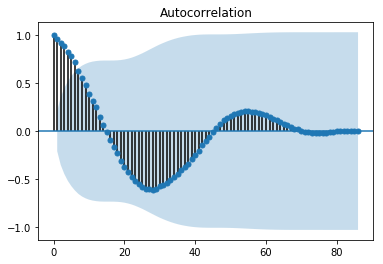

In [17]:
acf = tsaplots.plot_acf(econvars.txinadimp)

Da taxa de juros: 

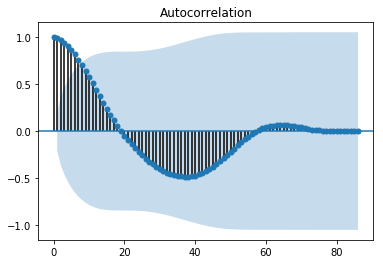

In [18]:
acf = tsaplots.plot_acf(econvars.juros)

Podemos claramente ver que ambas as séries possuem uma autocorrelação em t, o que atesta a não estacionariedade de ambas. 

Em seguida, iremos tornar as séries estacionárias ao diferenciá-las: 

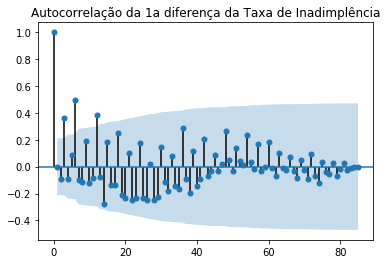

In [19]:
diff_inadimp = np.diff(econvars.txinadimp)
acf = tsaplots.plot_acf(diff_inadimp, alpha= 0.05,  title = "Autocorrelação da 1a diferença da Taxa de Inadimplência")

Notamos que a primeira diferença ainda exibe uma tendência na série da taxa de inadimplência. Para removê-la, tomaremos a segunda diferença da série: 

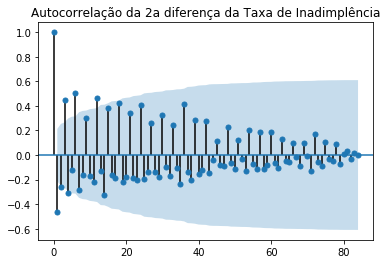

In [20]:
diff_diff_inadimp = np.diff(diff_inadimp)
acf = tsaplots.plot_acf(diff_diff_inadimp, alpha= 0.05,  title = "Autocorrelação da 2a diferença da Taxa de Inadimplência")

A série da segunda diferença da Taxa de Inadimplência é represenada no gráfico:

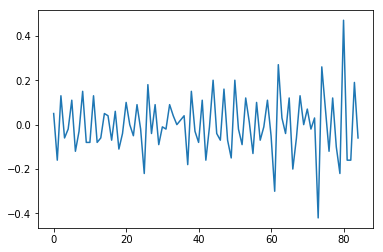

0    0.05
1   -0.16
2    0.13
3   -0.06
4   -0.02
dtype: float64

In [21]:
diff_diff_inadimp = pd.Series(diff_diff_inadimp)
grafdiff_diff_inadimp = plt.plot(diff_diff_inadimp)
plt.show()
diff_diff_inadimp.head()

Vamos fazer uma tentativa de elevar a série ao logaritmo:

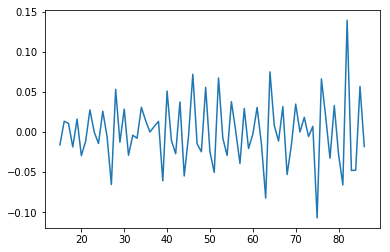

In [22]:
logdiffdiff = np.log(econvars.txinadimp).diff().diff().dropna()
logdiffdiff = logdiffdiff[13:]
#logdiffdiff.head()
graflogdiffdiff = plt.plot(logdiffdiff)
plt.show()

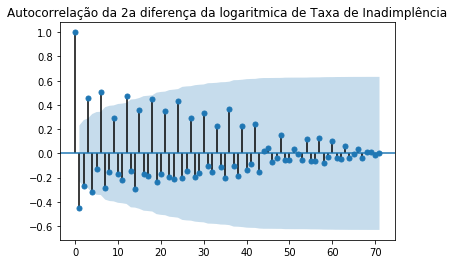

In [23]:
acf = tsaplots.plot_acf(logdiffdiff, alpha= 0.05,  title = "Autocorrelação da 2a diferença da logaritmica de Taxa de Inadimplência")


Vamos agora realizar um teste de raíz unitária em nossa série gerada pela segunda diferença logarítmica da Taxa de Inadimplência: 

In [24]:
adf_inadimp = smtsa.adfuller(logdiffdiff, regression=  'ctt') ## 'ctt' para checar a estacionariedade em tendência constante, linear e quadrática
adfout_diff_inad = pd.Series(adf[0:4], index = ["Estatística do Teste:", "P-valor", "# lags", "# observacoes"])
for key, value in adf_inadimp[4].items():
        adfout_diff_inad['Critical Value ({})'.format(key)] = value
print(adfout_diff_inad)

Estatística do Teste:    -1.590822
P-valor                   0.930455
# lags                   12.000000
# observacoes            74.000000
Critical Value (1%)      -4.572198
Critical Value (5%)      -3.933082
Critical Value (10%)     -3.614956
dtype: float64


Com o P-valor próximo de zero, temos hipóteses suficientes para rejeitar H0 com 5% de significância para o teste ADF. Logo, podemos assumir que pelas diferenças tomadas, tornamos nossa série de Taxa de Inadimplência estacionária.

Vamos agora realizar o mesmo procedimento para a Taxa de Juros:

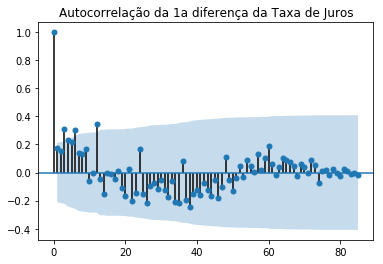

In [25]:
diff_juros = np.diff(econvars.juros)
acf = tsaplots.plot_acf(diff_juros, alpha= 0.05,  title = "Autocorrelação da 1a diferença da Taxa de Juros")

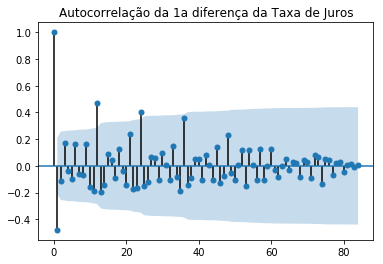

In [26]:
diff_diff_juros = np.diff(diff_juros)
acf = tsaplots.plot_acf(diff_diff_juros, alpha= 0.05,  title = "Autocorrelação da 1a diferença da Taxa de Juros")

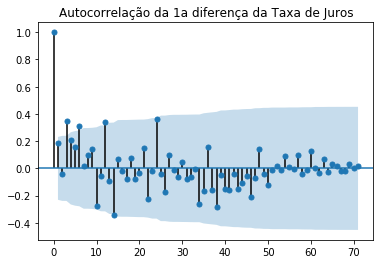

In [27]:
logdiffdiffjuros = np.log(econvars.juros).diff(14).diff().dropna() ##dif(14) devido a uma aparente sazonalidade em nossa série 
acf = tsaplots.plot_acf(logdiffdiffjuros, alpha= 0.05,  title = "Autocorrelação da 1a diferença da Taxa de Juros")

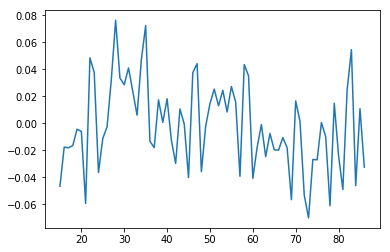

In [28]:
graflogdiffdiffjuros = plt.plot(logdiffdiffjuros)
plt.show()

Com nossa série diferenciada, vamos realizar um teste ADF para checar a presença ou não de raíz unitária: 

In [29]:
adf_juros = smtsa.adfuller(logdiffdiffjuros, regression=  'ctt') ## 'ctt' para checar a estacionariedade em tendência constante, linear e quadrática
adfout_diff_juros = pd.Series(adf[0:4], index = ["Estatística do Teste:", "P-valor", "# lags", "# observacoes"])
for key, value in adf_juros[4].items():
        adfout_diff_juros['Critical Value ({})'.format(key)] = value
print(adfout_diff_juros)

Estatística do Teste:    -1.590822
P-valor                   0.930455
# lags                   12.000000
# observacoes            74.000000
Critical Value (1%)      -4.575763
Critical Value (5%)      -3.934835
Critical Value (10%)     -3.616018
dtype: float64


Com um p-valor de 0.018671, temos evidências suficientes para rejeitar a Hipótese Nula de presença de raíz unitária em nossa série. Logo, podemos afirmar com 5% de significância que nossa série é estacionária. 

#### Ajuste do Modelo de Regressão Linear Simples com Mínimos Quadrados Ordinários

Agora que temos nossas séries devidamente estacionárias, podemos ajustar o modelo de Regressão Linear Simples por MQO. Para isto, utilizamos o pacote statsmodels. 

In [31]:
result_reg = sm.OLS(logdiffdiff, logdiffdiffjuros, missing = 'drop').fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:              txinadimp   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     7.570
Date:                Wed, 11 Jul 2018   Prob (F-statistic):            0.00753
Time:                        11:04:19   Log-Likelihood:                 132.30
No. Observations:                  72   AIC:                            -262.6
Df Residuals:                      71   BIC:                            -260.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
juros          0.3849      0.140      2.751      0.0

Como podemos ver dos resultados, o estimador da Taxa de Juros é igual a 0.3849,
seu erro padrão é 0.140,
os critérios de informação AIC e BIC são respectivamente -262.6 e -260.3, 
o R² é 0.096, 
e o p-valor da estatística F é próximo de 0.

#### Teste de Heterocedasticidade

A fim de testar a qualidade de nossos estimadores e do erro padrão, iremos realizar um teste de Breusch-Pagan para checar uma possível heterocedasticidade de nossa regressão. O teste de BP utiliza os resíduos ao quadrado de nossa regressão como variável dependente para outra regressão, com possíveis dados que possam estar gerando uma heterocedasticidade no modelo. (no caso, variável independente Taxa de Juros):


In [142]:
log2diffdiffjuros = np.asarray([logdiffdiffjuros, 1])
smstats.het_breuschpagan(resultado.resid, log2diffdiffjuros)
logdiffdiffjuros.shape

ValueError: not enough values to unpack (expected 2, got 1)

####Teste de Autocorrelação dos resíduos

In [57]:
ljung = smstats.acorr_ljungbox(result_reg.resid)
y=0
for x in ljung[1]:
    y+=x
resul_lbox = y/len(ljung[1])
print("P-valor do teste:" ,resul_lbox)
#print(ljung[1])





P-valor do teste: 1.82528098112e-05


Como o teste de Ljung Box retornou um p-valor<0.05, podemos rejeitar a hipótese nula de inexistência de autocorrelação nos resíduos e chegar a conclusão que a 5% de significância, nossa série possui um problema de autocorrelação serial. 

####Teste de Cointegração de Johansen

In [33]:
coint_test = smtsa.coint(econvars.juros, econvars.txinadimp)
print("P-valor do teste de Cointegração de Johansen: ",coint_test[1])

P-valor do teste de Cointegração de Johansen:  0.351035590398


Como o p-valor do teste de cointegraço de johansen é maior que 0.05, não podemos afirmar a 5% de significância que existe uma relação de cointegração entre as séries da Taxa de Juros e Taxa de Inadimplência. (Talvez se tivesse mais observações...) 

###Salvar o relatório em um arquivo de texto: 

Para futura referência, vamos salvar nossas saídas em um arquivo de texto:

In [66]:
arquivo = open("saidasrelatorio.txt", "w") ##abrindo para leitura/gravação e criando se não existir
arquivo.write("Resumo do Relatório Econométrico  \n")
arquivo.write("\nTeste ADF para a Taxa de Inadimplencia:  \n")
arquivo.write(str(adfoutput_inad))
arquivo.write("\n\nTeste ADF para a Taxa de Juros: \n")
arquivo.write(str(adfoutput_juros))
arquivo.write("\n\nTeste ADF para a Taxa de Indimplencia Diferenciada:\n")
arquivo.write(str(adfout_diff_inad))
arquivo.write("\n\nTeste ADF para a Taxa de Juros Diferenciada:\n")
arquivo.write(str(adfout_diff_juros))
arquivo.write("\n\nResultado da Regressao por MQO:\n")
arquivo.write("\n" + str(result_reg.summary()))
arquivo.write("\n\nResultado do Teste de Ljung-Box para autocorrelação dos resíduos:\n")
arquivo.write("Pvalor do teste:" + str(resul_lbox))


33